In [433]:
import pandas as pd 
import numpy as np
import glob
import re
import os
import scipy.stats
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import chi2

## 1/(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [2]:
folder_name = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
columns = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
train_sets = []
test_sets = []
 
# list_of_files = sorted( filter( os.path.isfile,
#                         glob.glob('../data/AReM/bending1/' + '*') ) )
# path = "../data/AReM/bending1/*.csv"
for item in folder_name:
    path = '../data/AReM/' + item + '/*'
    sorted_files = sorted(filter(os.path.isfile, glob.glob(path)))
    
    if item in ['bending1', 'bending2']:
        for fname in sorted_files:
            index = re.findall("\d+", fname)[1]
            files = []
            if index not in ['1','2']:
                train_sets.append(fname)
            else:
                test_sets.append(fname)
    else:
        for fname in sorted_files:
            index = re.findall("\d+", fname)[0]
            if index not in ['1','2', '3']:
                train_sets.append(fname)
            else:
                test_sets.append(fname)
# length of train_sets is 69, length of test_sets is 19
len(test_sets), len(train_sets)

(19, 69)

## 1/(c)  Feature Extraction

#### i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

Minimum, maximum, mean, median, std, firstQuartile(25%), in-terquartile(50%), thirdQuartile(75%)

Means in each of the 𝑑 dimensions;
Standard deviations of the 𝑑 dimensions;
Skewness, Kurtosis and Higher order moments of the 𝑑 dimensions;
Maximum and Minimum values.

#### ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly

In [140]:
# Training set
df_train = pd.DataFrame()

for path in train_sets:
    label = path.split('/')[3]
    table = pd.read_csv(path, skiprows=4, header = 0, names = columns)
    data = {}
    des = table.describe().T
    for i in np.arange(1,7):
        col = columns[i]
        data['min' + str(i)] = des['min'][col]
        data['max' + str(i)] = des['max'][col]
        data['mean' + str(i)] = des['mean'][col]
        data['median' + str(i)] = table[col].median()
        data['std' + str(i)] = des['std'][col]
        data['1st_quartile' + str(i)] = des['25%'][col]
        data['3rd_quartile' + str(i)] = des['75%'][col]
        df1 = pd.DataFrame(data = data, index = [0])
    df1['label'] = label
    df_train = pd.concat([df_train, df1])
df_train = df_train.reset_index(drop=True)
display(df_train)

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,1st_quartile5,3rd_quartile5,min6,max6,mean6,median6,std6,1st_quartile6,3rd_quartile6,label
0,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400,bending1
1,33.00,47.75,42.179813,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000,bending1
2,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000,bending1
3,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.500,0.622534,0.43,0.8700,bending1
4,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555313,0.490,0.487826,0.00,0.8300,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,4.223792,...,14.2500,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050,walking
65,21.50,51.00,34.935813,35.500,4.645944,32.00,38.0625,0.0,12.21,4.115750,...,14.2375,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000,walking
66,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,4.396958,...,13.7500,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200,walking
67,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,4.398833,...,14.0000,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600,walking


In [4]:
# test set
df_test = pd.DataFrame()

for path in test_sets:
    label = path.split('/')[3]
    table = pd.read_csv(path, skiprows=4, header = 0, names = columns)
    data = {}
    des = table.describe().T
    for i in np.arange(1,7):
        col = columns[i]
        data['min' + str(i)] = des['min'][col]
        data['max' + str(i)] = des['max'][col]
        data['mean' + str(i)] = des['mean'][col]
        data['median' + str(i)] = table[col].median()
        data['std' + str(i)] = des['std'][col]
        data['1st_quartile' + str(i)] = des['25%'][col]
        data['3rd_quartile' + str(i)] = des['75%'][col]
        df1 = pd.DataFrame(data = data, index = [0])
    df1['label'] = label
    df_test = pd.concat([df_test, df1])
df_test = df_test.reset_index(drop=True)
display(df_test)

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,1st_quartile5,3rd_quartile5,min6,max6,mean6,median6,std6,1st_quartile6,3rd_quartile6,label
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300,bending1
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372438,...,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300,bending1
2,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870,bending2
3,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300,bending2
4,24.25,45.00,37.177042,36.250,3.581301,34.5000,40.2500,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,cycling
5,28.75,44.75,37.561188,36.875,3.226507,35.2500,40.2500,0.0,9.91,2.080688,...,18.0000,21.5000,0.0,9.62,2.765896,2.450,1.769203,1.4100,3.770,cycling
6,22.00,44.67,37.058708,36.000,3.710180,34.5000,40.0625,0.0,14.17,2.438146,...,16.0000,21.0000,0.0,8.55,2.983750,2.570,1.815730,1.5000,4.150,cycling
7,23.50,30.00,27.716375,27.500,1.442253,27.0000,29.0000,0.0,1.79,0.363688,...,5.5000,10.7500,0.0,4.50,0.734271,0.710,0.613688,0.4300,1.000,lying
8,24.75,48.33,44.182937,48.000,7.495615,48.0000,48.0000,0.0,3.11,0.101875,...,2.0000,5.5425,0.0,3.91,0.692771,0.500,0.675781,0.3225,0.940,lying
9,48.00,48.25,48.004167,48.000,0.032038,48.0000,48.0000,0.0,0.43,0.007167,...,4.6700,10.0000,0.0,2.50,0.641229,0.500,0.388372,0.4600,0.830,lying


In [5]:
df_combine_feature = pd.concat([df_train,df_test])
df_combine_feature

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,1st_quartile5,3rd_quartile5,min6,max6,mean6,median6,std6,1st_quartile6,3rd_quartile6,label
0,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.500,0.0,1.79,0.493292,0.430,0.513506,0.000,0.940,bending1
1,33.00,47.75,42.179813,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.330,0.0,2.18,0.613521,0.500,0.524317,0.000,1.000,bending1
2,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.250,0.0,1.79,0.383292,0.430,0.389164,0.000,0.500,bending1
3,37.00,48.00,43.454958,43.250,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.000,0.0,5.26,0.679646,0.500,0.622534,0.430,0.870,bending1
4,36.25,48.00,43.969125,44.500,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.750,0.0,2.96,0.555313,0.490,0.487826,0.000,0.830,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,35.50,46.25,43.174938,43.670,1.989052,42.50,44.5000,0.0,2.12,0.506583,...,12.7500,16.500,0.0,5.72,0.911979,0.830,0.666161,0.470,1.220,standing
15,32.75,47.00,42.760563,44.500,3.398919,41.33,45.3725,0.0,3.34,0.486167,...,13.0000,18.565,0.0,5.73,0.842271,0.710,0.722165,0.430,1.090,standing
16,19.33,43.50,34.227771,35.500,4.889576,30.50,37.7500,0.0,14.50,3.995729,...,14.7500,18.670,0.0,9.74,3.394125,3.100,1.792090,2.105,4.425,walking
17,12.50,45.00,33.509729,34.125,4.850923,30.50,36.7500,0.0,13.05,4.450771,...,14.6275,18.750,0.0,8.96,3.378479,3.085,1.787360,2.060,4.440,walking


#### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [6]:
#reference: https://www.statology.org/bootstrapping-in-python/
#convert array to sequence
data = (df_combine_feature.iloc[:, :-1],)

#calculate 90% bootstrapped confidence interval for std
bootstrap_ci = bootstrap(data, np.std, confidence_level=0.90,
                         random_state=1, method='percentile')

#view 95% boostrapped confidence interval

a = bootstrap_ci.confidence_interval
indexes = df_combine_feature.iloc[:, :-1].columns
dict1 = {}
std_result = df_combine_feature.iloc[:, :-1].describe().T['std']
for i in np.arange(len(a[0])):
    dict1[indexes[i]] = [[a[0][i], a[1][i]], std_result[i]]
df_90_ci = pd.DataFrame.from_dict(data = dict1, orient='index', columns = ['interval', 'std'])
display(df_90_ci)
print('df_90_ci shape is ', df_90_ci.shape)

,interval,std
min1,"[8.220030583677477, 10.709495603487852]",9.569975
max1,"[3.314995620842594, 5.2855270712546805]",4.394362
mean1,"[4.681186294275009, 5.849899034669991]",5.335718
median1,"[4.766020086494439, 5.967149662012756]",5.440054
std1,"[1.5630191079436118, 1.937058465532739]",1.772153
1st_quartile1,"[5.543508426610177, 6.603828876321536]",6.153590
3rd_quartile1,"[4.307611950806717, 5.8076200459056935]",5.138925
min2,"[0.0, 0.0]",0.000000
max2,"[4.606956668619024, 5.371280286178948]",5.062729
mean2,"[1.3898556652290928, 1.6960694764705275]",1.574164


df_90_ci shape is  (42, 2)


#### iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

From my own judgement, the three most important features are mean, median and std( confidence interval is relatively narrow).

## 2. ISLR 3.7.4

#### I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.
#### (a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

We would expect the training residual sum of squares for the cubic regression is lower. Because cubic regression has more terms than the linear regression,thus the RSS will be smaller/reduce in the model.

#### (b) Answer (a) using test rather than training RSS.

For the test RSS, the one for the linear regression would be smaller. The test RSS for the cubic regression is bigger because it has more terms and the model would overfit the data.

#### (c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

Since we don't know how far it is from linear, the training RSS for the cubic regression would be lower. Since it has more terms, the regression has higher flexibility and fits the data better.

#### (d) Answer (c) using test rather than training RSS.

For this question, there is not enough information to tell. We don't know exactly how far it is from linear. We can not determine if the regression needs more flexibility or not.

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

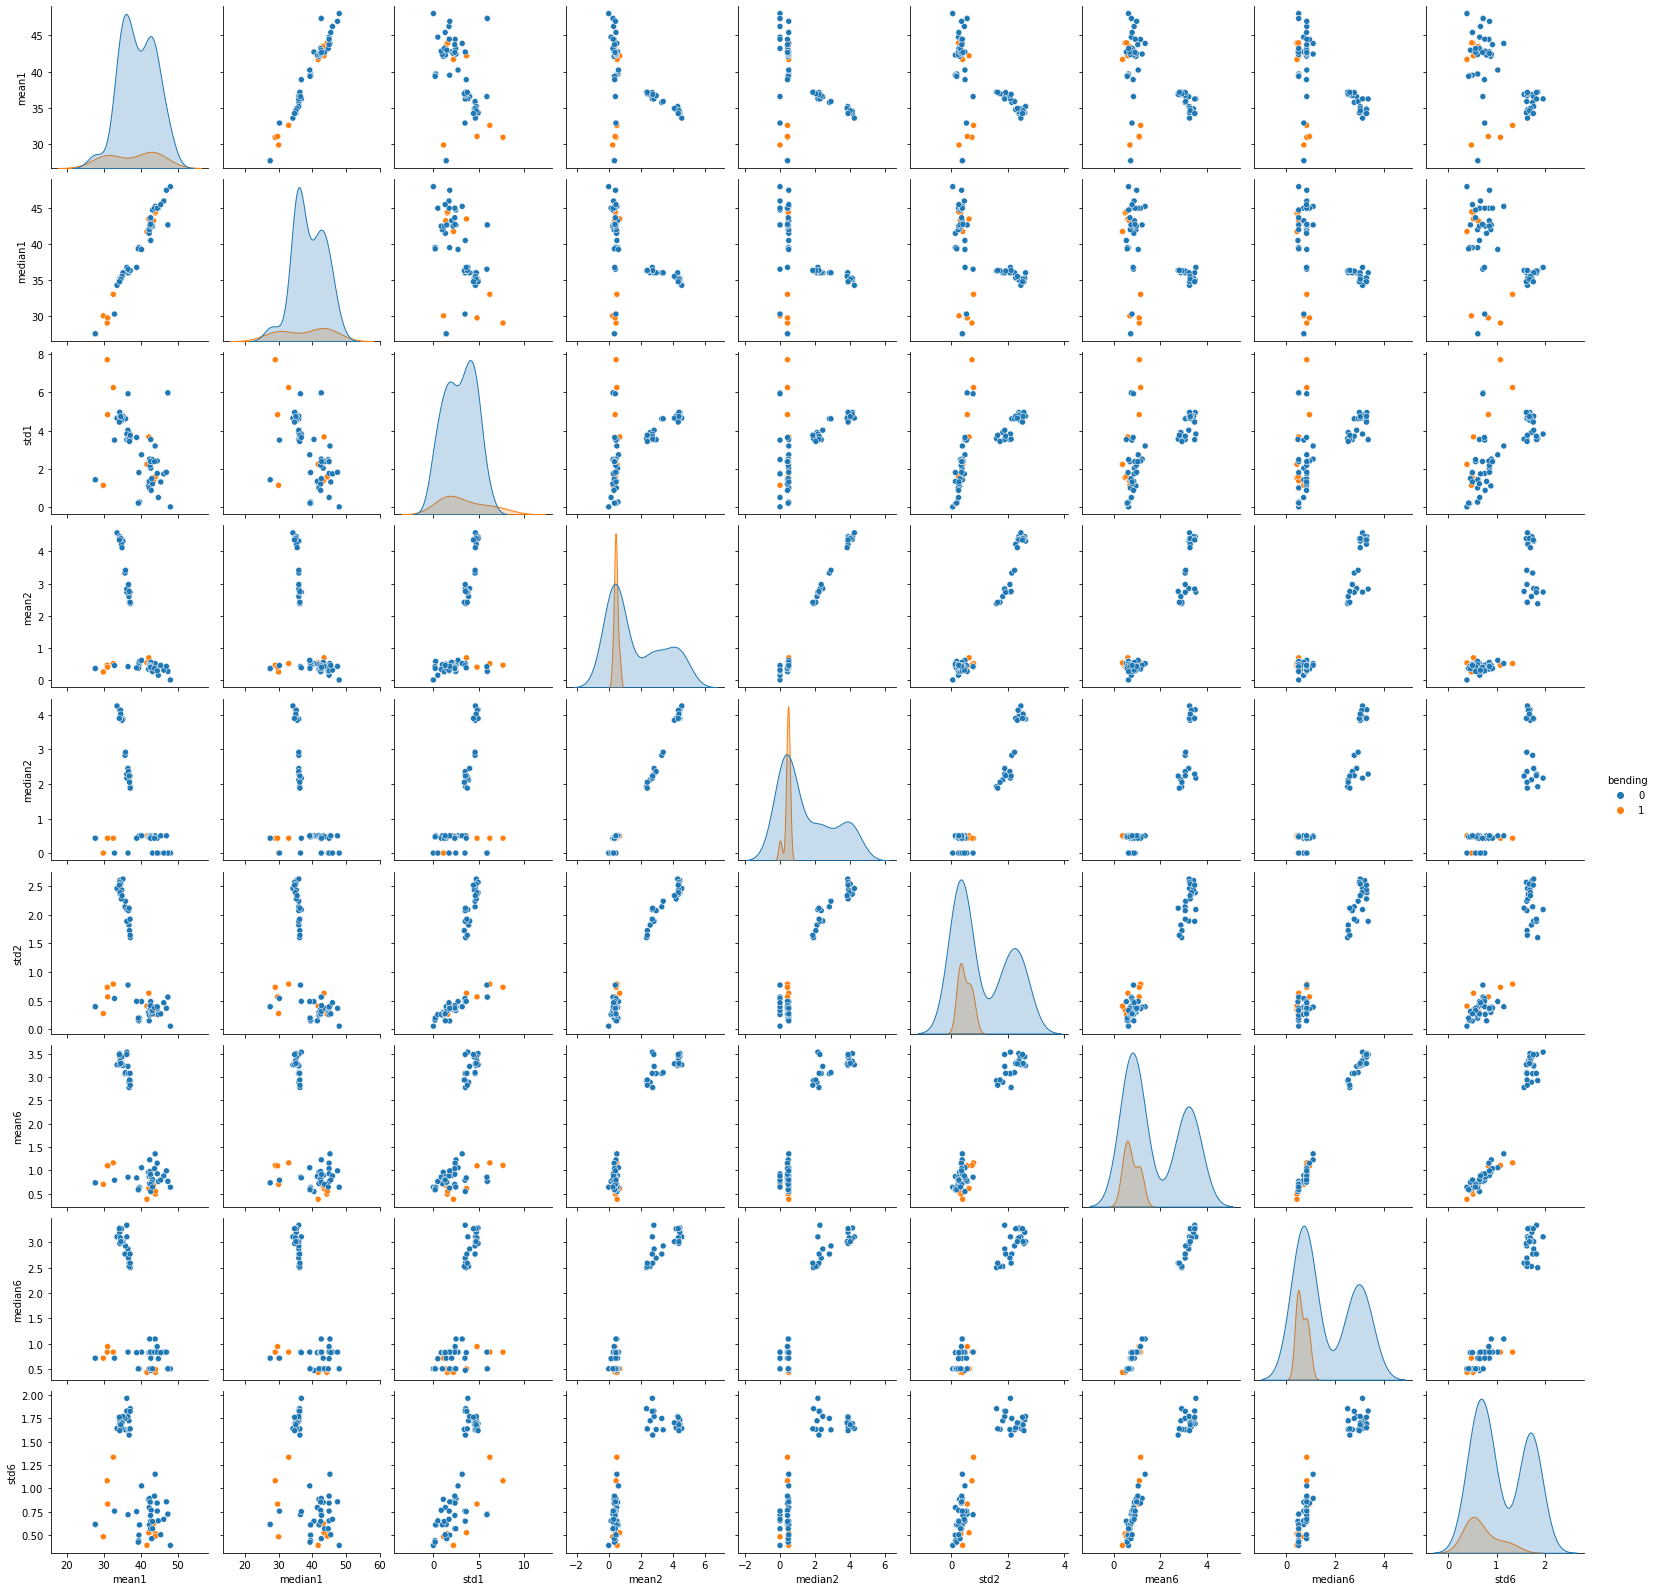

In [7]:
# features from i(c)iv are mean, median and std
df_126 = df_train[['mean1', 'median1', 'std1', 'mean2', 'median2', 'std2','mean6', 'median6', 'std6']]
# display(df_126)
# 1 is bending, 0 is non-bending
bend_type = [1 if x in ['bending1', 'bending2'] else 0 for x in df_train['label']]
a = df_126.copy()
a['bending'] = bend_type
sns.pairplot(a, vars=a.columns[0:9], hue ='bending')
plt.show()

#### ii.Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i

In [176]:
# this function takes in a table and index
# index is used to change the column name. eg: min6, min7
def time_series(table, index):
    data = {}
    des = table.describe().T
    for i, j in zip(index, np.arange(1, 7)):
        col = columns[j]
        data['min' + str(i)] = des['min'][col]
        data['max' + str(i)] = des['max'][col]
        data['mean' + str(i)] = des['mean'][col]
        data['median' + str(i)] = table[col].median()
        data['std' + str(i)] = des['std'][col]
        data['1st_quartile' + str(i)] = des['25%'][col]
        data['3rd_quartile' + str(i)] = des['75%'][col]
        df = pd.DataFrame(data = data, index = [0])
    return df

In [177]:
# this is the function of spliting dataframe.
# df is the dataframe, l is the number of splits
def split_table(df, l):
    if l == 1:
        return [df]
    size = round((len(df) / l))
    splits = [df.iloc[i:i+size,:] for i in range(0, len(df),size)]
    
    tables = []
    sum = 0
    i = 0
    rest = pd.DataFrame()
    for item in splits:
        i += 1
#     print(i)
        if i > l:
            rest = df.iloc[sum:]
#             print(len(rest))
            break
        sum += len(item)
        tables.append(item)
#         print(len(item))
    if not rest.empty:
        tables[-1] = pd.concat([tables[-1], rest])
    return tables

In [215]:
def create_df(datasets, l):
    df_train2 = pd.DataFrame()

    for path in datasets:
        label = path.split('/')[3]
        table = pd.read_csv(path, skiprows=4, header = 0, names = columns)
        lists_of_tables = split_table(table, l)
        combined_series = pd.DataFrame()
        index = np.arange(1,7)
        for item in lists_of_tables:
            df = time_series(item, index)
            combined_series = pd.concat([combined_series, df], axis = 1)
            index += 6
        combined_series['label'] = label
        df_train2 = pd.concat([df_train2, combined_series])
    df_train2 = df_train2.reset_index(drop=True)
    return df_train2
df_train2 = create_df(train_sets, 2)
df_train2

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,1st_quartile11,3rd_quartile11,min12,max12,mean12,median12,std12,1st_quartile12,3rd_quartile12,label
0,36.50,46.50,44.057167,44.500,1.556971,43.2500,45.0000,0.0,1.50,0.381042,...,33.0000,36.2500,0.00,1.50,0.388333,0.000,0.478528,0.0000,0.7100,bending1
1,33.75,47.75,43.278875,45.000,3.473355,42.0000,45.2500,0.0,3.00,0.673292,...,28.7500,33.7500,0.00,2.18,0.586083,0.470,0.491873,0.0000,0.8700,bending1
2,33.00,45.75,41.621208,42.330,3.118644,39.6525,44.2500,0.0,2.83,0.623083,...,28.3100,30.5625,0.00,1.50,0.347500,0.430,0.363144,0.0000,0.5000,bending1
3,39.00,48.00,44.117042,45.000,1.359836,43.5000,45.0000,0.0,1.30,0.250042,...,22.5000,23.7500,0.00,4.06,0.543875,0.500,0.473445,0.4300,0.7100,bending1
4,36.67,45.00,43.486208,43.710,1.281976,42.3300,44.5000,0.0,1.30,0.378667,...,21.0000,23.5000,0.00,2.96,0.585750,0.500,0.487918,0.4225,0.8300,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,22.33,46.00,34.966250,35.500,4.733014,32.0000,38.7500,0.0,12.68,4.207958,...,14.0000,18.5000,0.00,9.39,3.430208,3.350,1.647979,2.1700,4.4400,walking
65,21.50,45.67,34.737042,35.500,4.276717,32.0000,37.7500,0.0,12.21,4.217333,...,14.5000,18.2500,0.00,10.21,3.225917,3.085,1.665326,2.0500,4.3500,walking
66,18.33,45.00,33.886458,34.375,5.143776,30.4575,37.5000,0.0,12.44,4.332208,...,13.6275,18.2500,0.00,8.01,3.274750,2.955,1.670593,2.0500,4.4375,walking
67,18.33,44.00,34.836458,35.750,4.869092,32.0000,38.6900,0.0,12.38,4.257750,...,13.9375,18.2500,0.47,8.84,3.409458,3.110,1.707089,2.1700,4.3450,walking


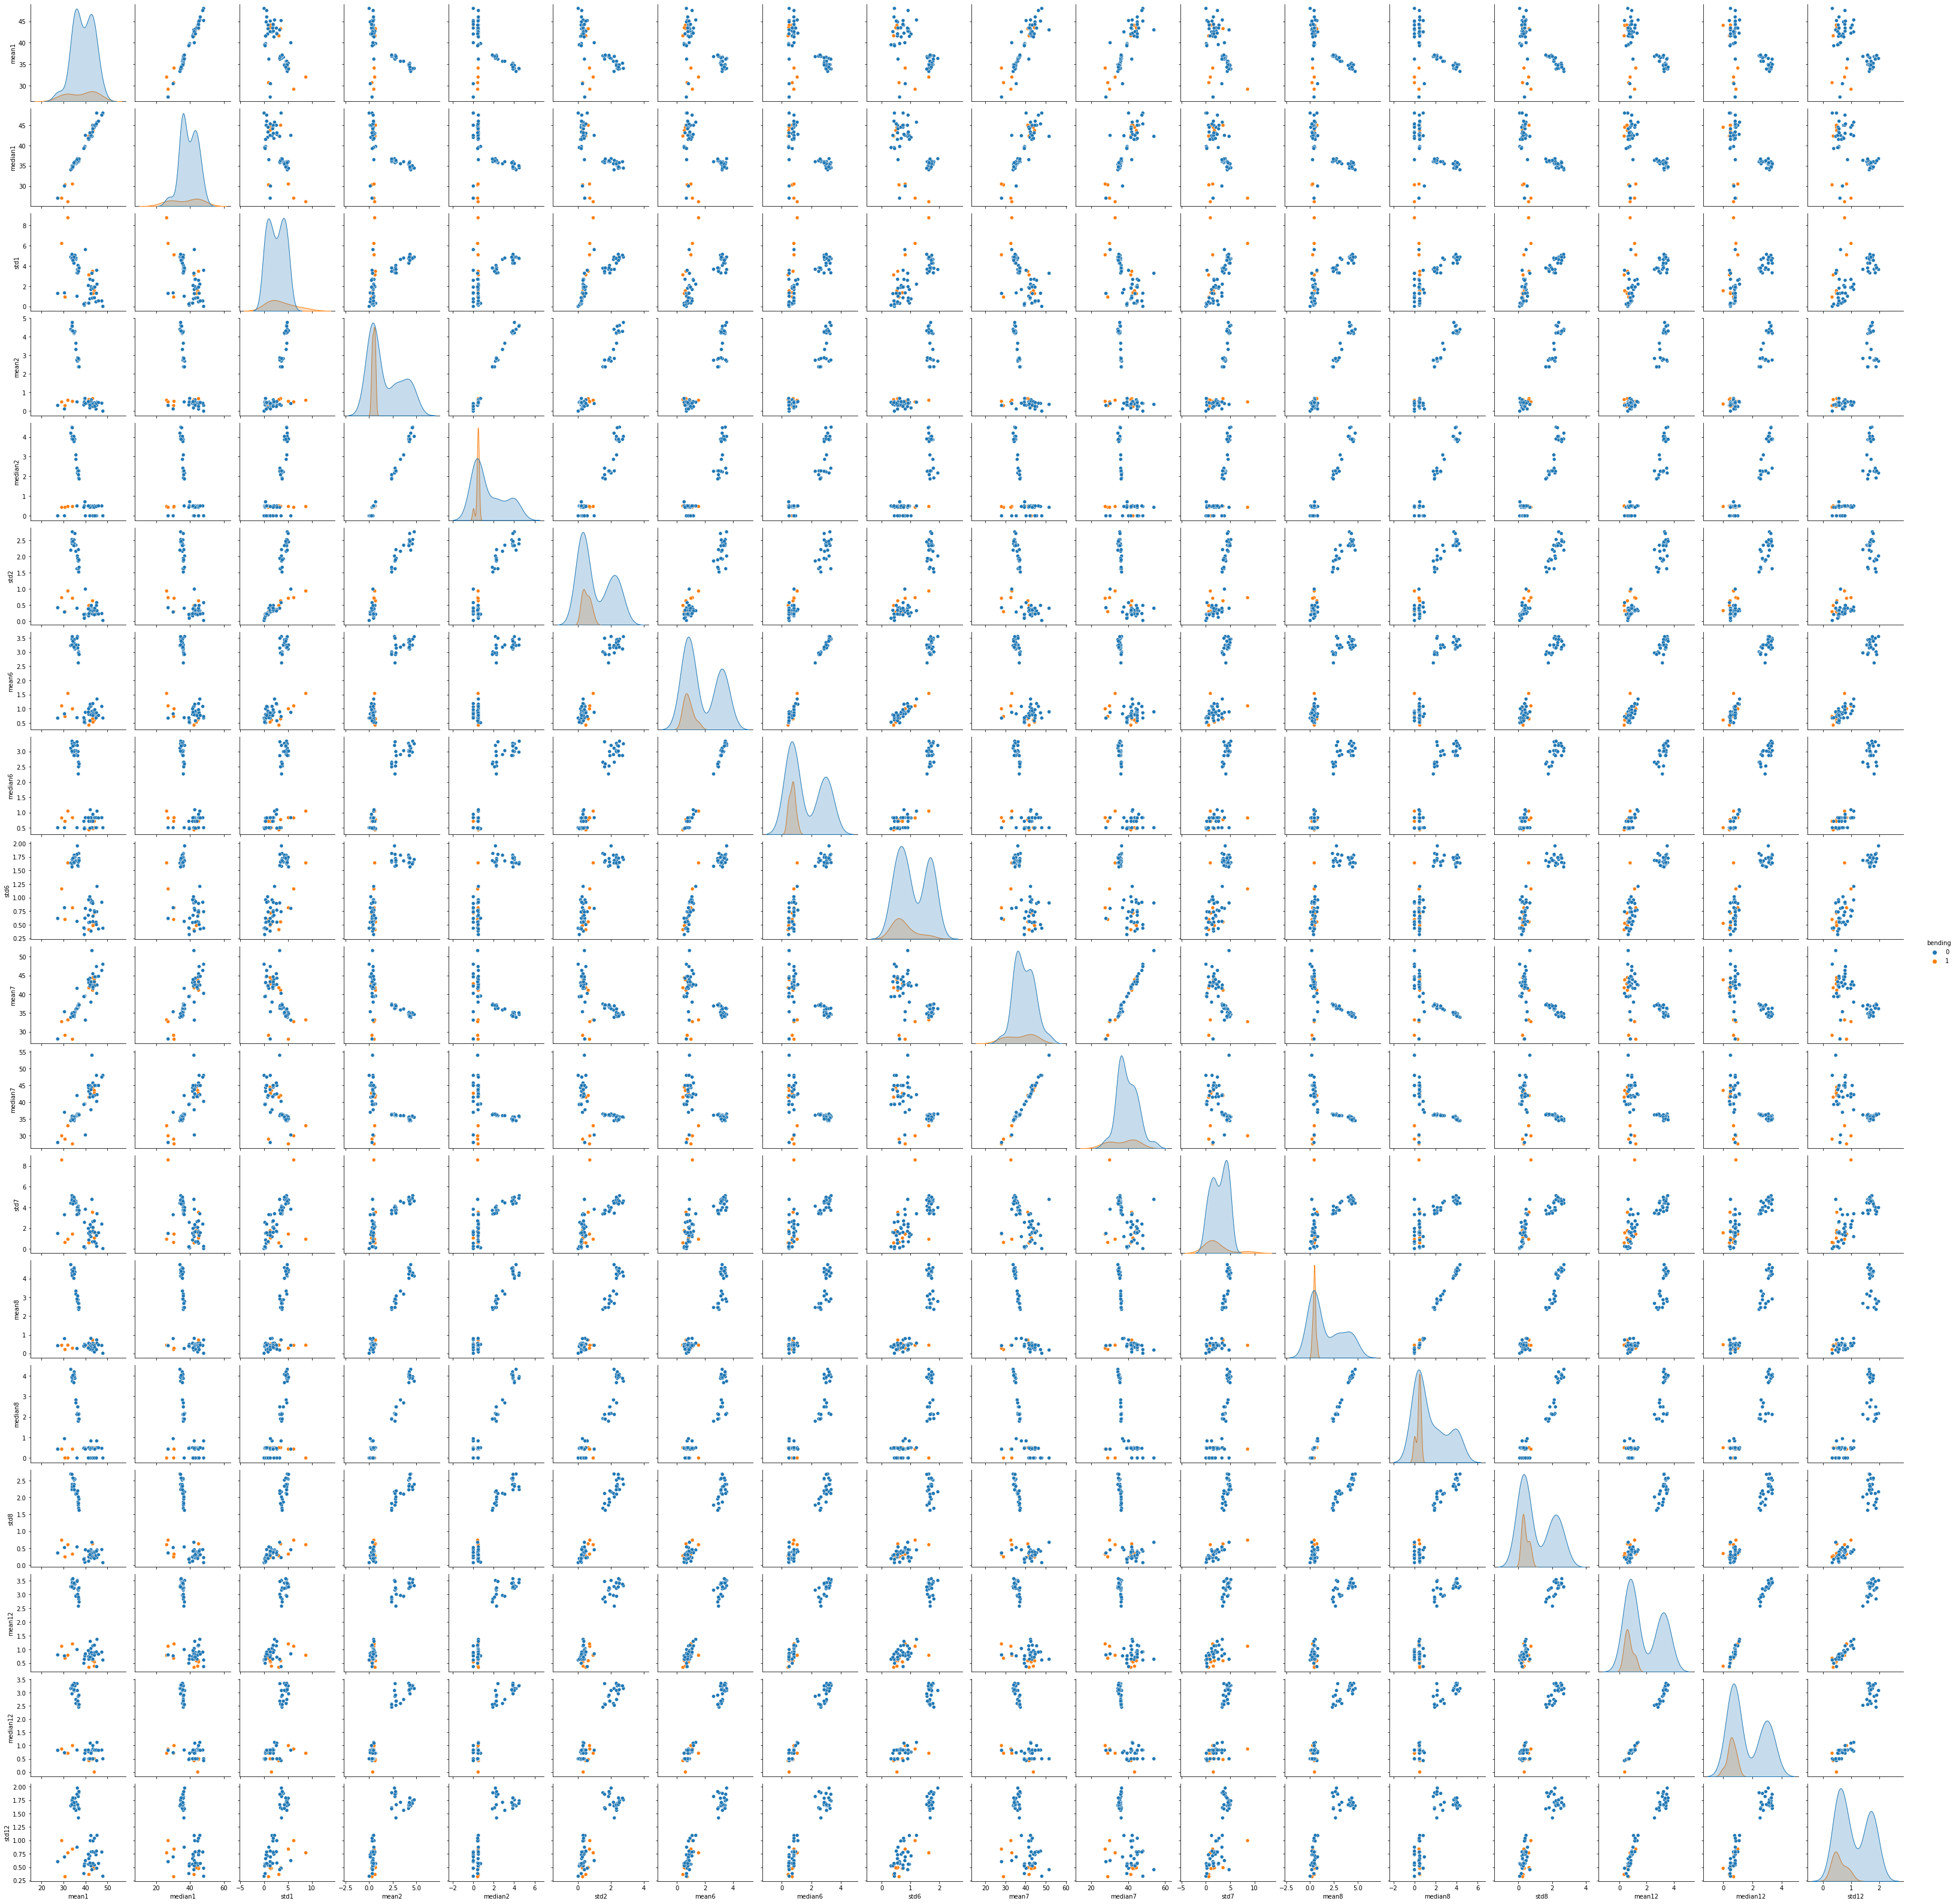

In [217]:
# select features from i(c)iv are mean, median and std, from two parts 1, 2, 6, 7, 8, 12
df_ii = df_train2[['mean1', 'median1', 'std1', 'mean2', 'median2', 'std2','mean6', 'median6', 'std6',\
                 'mean7', 'median7', 'std7', 'mean8', 'median8', 'std8','mean12', 'median12', 'std12']]
# display(df_ii)
# 1 is bending, 0 is non-bending
bend_type = [1 if x in ['bending1', 'bending2'] else 0 for x in df_train2['label']]
a = df_ii.copy()
a['bending'] = bend_type
sns.pairplot(a, vars=a.columns[0:18], hue ='bending')
plt.show()

Findings: Compared to the scatterplot in 2a/i, the distributions look similar.

#### iii. Break each time series in your training set into l∈ {1,2, . . . ,20}time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features

In [310]:
best_p = []
scores = []


for l in np.arange(1, 21):
#     
    train_series = create_df(train_sets, l)
    X_train = train_series.iloc[:, :-1]
    y_train = [1 if x in ['bending1', 'bending2'] else 0 for x in train_series.iloc[:, -1]]
    model = LogisticRegression(solver='lbfgs', penalty = 'none', max_iter = 300)
    
#     use time-domian features selected from previous questions
    substring_list = ['mean', 'median' , 'std']
    time_domain_list = []
    for item in X_train.columns:
        if any(map(item.__contains__, substring_list)):
            time_domain_list.append(item)
    x_train = X_train[time_domain_list]
  
    
# use rfecv to select features    
    c = StratifiedKFold(n_splits=5, shuffle=True, random_state=68) #, shuffle=True, random_state=69
    r = RFECV(model, step = 1, cv = c, scoring='accuracy') #, scoring='accuracy'
    rfe = r.fit(x_train, y_train)
    F1_Score = f1_score(y_train, rfe.predict(x_train))
    score = rfe.grid_scores_
    best_p.append(rfe.n_features_)
    scores.append(score )
    
    print('l', l)
    print('p :', rfe.n_features_)
    print('Best features :', x_train.columns[rfe.support_])
    print('F1-score', round(F1_Score, 2))
    print('score', max(score))
    print('\n')

l 1
p : 10
Best features : Index(['mean1', 'mean2', 'std2', 'median3', 'mean4', 'median4', 'mean5',
       'std5', 'mean6', 'median6'],
      dtype='object')
F1-score 1.0
score 0.9428571428571428


l 2
p : 5
Best features : Index(['mean5', 'mean6', 'mean8', 'mean12', 'median12'], dtype='object')
F1-score 1.0
score 0.9285714285714285


l 3
p : 5
Best features : Index(['median3', 'mean5', 'median5', 'std7', 'mean13'], dtype='object')
F1-score 1.0
score 0.9714285714285715


l 4
p : 4
Best features : Index(['mean5', 'median13', 'std13', 'mean14'], dtype='object')
F1-score 1.0
score 0.9428571428571428


l 5
p : 6
Best features : Index(['mean5', 'median5', 'mean11', 'mean19', 'median19', 'mean27'], dtype='object')
F1-score 1.0
score 0.9857142857142858


l 6
p : 9
Best features : Index(['mean5', 'median5', 'mean11', 'median11', 'median19', 'std19', 'mean25',
       'mean26', 'mean33'],
      dtype='object')
F1-score 1.0
score 0.9714285714285715


l 7
p : 4
Best features : Index(['mean5', 'mea

In [316]:
# find the best l = 5 and p = ['mean5', 'median5', 'mean11', 'mean19', 'median19', 'mean27']
scores_max = []
for item in scores:
    scores_max.append(max(item))
for i in range(len(scores_max)):
    if scores_max[i] == max(scores_max):
        print('best l is', i + 1)
        print('best score is', scores_max[i])

best l is 5
best score is 0.9857142857142858


Conclusion: the right way is to use stratified cross validation as cv in RFECV, and select the best split l and optimal numbers of features from RFECV. And fit the training data using best feautres.This is better than using p-values for every models. The best pair (l,p) is (5,6). The p-values are calculated below.

#### iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [426]:
l = 5, p = 6
train_iv = create_df(train_sets, l).iloc[:, :-1]
X_train = train_iv[['mean5', 'median5', 'mean11', 'mean19', 'median19', 'mean27']]
y_train = [1 if x in ['bending1', 'bending2'] else 0 for x in train_series.iloc[:, -1]]
model_iv = LogisticRegression(solver='lbfgs', penalty = 'none', max_iter = 300).fit(X_train, y_train)
pred_y = model_iv.predict(X_train)
cmatric = confusion_matrix(y_train, pred_y)
print('confusion matrix\n', cmatric)

confusion matrix
 [[60  0]
 [ 0  9]]


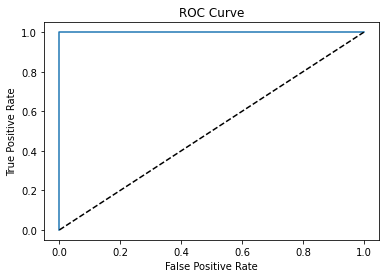

AUC is: 1.0


In [432]:
# plotting resource: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
# plotting ROC: https://stackoverflow.com/questions/37110924/how-to-plot-roc-curve-with-matplotlib-python
fpr, tpr, thresholds = roc_curve(y_train, pred_y)

# Print ROC curve
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC is:', auc)

In [455]:
# find p-values and coefficients using chi2
# chi2 resource: https://stackoverflow.com/questions/22306341/python-sklearn-how-to-calculate-p-values
coef = model_iv.coef_ 
scores, pvalues = chi2(X_train, y_train)
for i, feature in enumerate(X_train):
    c = round(coef[0][i], 4)
    p = round(pvalues[i], 4)
    print('feature', feature, ':coefficient is', c, 'p-values is', p)

feature mean5 :coefficient is 9.6865 p-values is 0.0
feature median5 :coefficient is 8.2428 p-values is 0.0
feature mean11 :coefficient is 8.2127 p-values is 0.0
feature mean19 :coefficient is -6.3975 p-values is 0.2784
feature median19 :coefficient is -5.6474 p-values is 0.2805
feature mean27 :coefficient is -4.9676 p-values is 0.3572


#### v.Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously

In [468]:
l = 5
test_v = create_df(test_sets, l)
#     use time-domian features selected from previous questions
substring_list = ['mean', 'median' , 'std']
time_domain_list = []
for item in test_v.columns:
    if any(map(item.__contains__, substring_list)):
        time_domain_list.append(item)
x_test = test_v[time_domain_list]
y_test = [1 if x in ['bending1', 'bending2'] else 0 for x in test_v.iloc[:, -1]]
x_test_select = x_test[['mean5', 'median5', 'mean11', 'mean19', 'median19', 'mean27']]

y_pred_test = model_iv.predict(x_test_select)
cmatric_test = confusion_matrix(y_test, y_pred_test)
test_score = model_iv.score(x_test_select, y_test)
train_score = model_iv.score(X_train, y_train)
print('cross-validation accuracy on train set:', train_score)
print('cross-validation accuracy on test  set:', test_score)
print('\n')
print('confusion matrix\n', cmatric_test)

cross-validation accuracy on train set: 1.0
cross-validation accuracy on test  set: 1.0


confusion matrix
 [[15  0]
 [ 0  4]]


#### vi.Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Yes, classes are well-separated to cause insatability. When I tried to run stats model for logsitic regression, there always have convergence warnings.

#### vii.From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

Yes, there are imbalanced classes. TN have more samples than TP.

### (b) Binary Classification Using L1-penalized logistic regression

#### i.Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L 1 penalty in your logistic regression objective function (or C , the budget). Packages usually perform cross-validation for λ automatically

In [473]:
# using L1-penalized logistic regression
# resource:https://chrisalbon.com/code/machine_learning/logistic_regression/logistic_regression_with_l1_regularization/
# using normalize instead of StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import normalize
f1 = []
scores = []
models = []


for l in np.arange(1, 21):
#     
    train_series = create_df(train_sets, l)
    X_train = train_series.iloc[:, :-1]
    y_train = [1 if x in ['bending1', 'bending2'] else 0 for x in train_series.iloc[:, -1]]
    model = LogisticRegression(solver='lbfgs', penalty = 'none', max_iter = 320)
    
#     use time-domian features selected from previous questions
    substring_list = ['mean', 'median' , 'std']
    time_domain_list = []
    for item in X_train.columns:
        if any(map(item.__contains__, substring_list)):
            time_domain_list.append(item)
    x_train = X_train[time_domain_list]
    
#     normalized data
    x_train = normalize(x_train, norm = 'l1')
    model = LogisticRegressionCV(penalty='l1', cv = 5, solver='liblinear', random_state = 68,scoring = 'accuracy',\
                                max_iter = 300)
    model.fit(x_train, y_train)
    
    F1_Score = f1_score(y_train, model.predict(x_train))
    score = model.score(x_train,y_train)
    f1.append(F1_Score)
    models.append(model)
    scores.append(score)
    
    print('l', l)
    print('F1-score', round(F1_Score, 2))
    print('score', score)
    print('\n')
      

l 1
F1-score 0.8
score 0.9565217391304348


l 2
F1-score 1.0
score 1.0


l 3
F1-score 1.0
score 1.0


l 4
F1-score 1.0
score 1.0


l 5
F1-score 1.0
score 1.0


l 6
F1-score 1.0
score 1.0


l 7
F1-score 1.0
score 1.0


l 8
F1-score 0.94
score 0.9855072463768116


l 9
F1-score 1.0
score 1.0


l 10
F1-score 1.0
score 1.0


l 11
F1-score 0.94
score 0.9855072463768116


l 12
F1-score 1.0
score 1.0


l 13
F1-score 1.0
score 1.0


l 14
F1-score 0.94
score 0.9855072463768116


l 15
F1-score 1.0
score 1.0


l 16
F1-score 1.0
score 1.0


l 17
F1-score 0.94
score 0.9855072463768116


l 18
F1-score 1.0
score 1.0


l 19
F1-score 1.0
score 1.0


l 20
F1-score 1.0
score 1.0




In [489]:
# choose best l, p
best_score = max(scores)
best_l = 0
best_model = 0
# choose the minimum l to prevent overfitting
for i in range(len(scores)):
    if scores[i] == best_score:
        best_l = i + 1
        best_model = models[i]
        break
for item in models:
    print(item.n_features_in_)
best_p = best_model.n_features_in_
print('\nbest l, p:', best_l, best_p)

18
36
54
72
90
108
126
144
162
180
198
216
234
252
270
288
306
324
342
360

best l, p: 2 36


#### ii.Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

In [499]:
l = 2
test_v = create_df(test_sets, l)
train_v = create_df(test_sets, l)
#     use time-domian features selected from previous questions
def time_domain_df(df):
    substring_list = ['mean', 'median' , 'std']
    time_domain_list = []
    for item in df.columns:
        if any(map(item.__contains__, substring_list)):
            time_domain_list.append(item)
    return time_domain_list
x_test = test_v[time_domain_df(test_v)]
x_train = train_v[time_domain_df(train_v)]
y_train = [1 if x in ['bending1', 'bending2'] else 0 for x in train_v.iloc[:, -1]]
y_test = [1 if x in ['bending1', 'bending2'] else 0 for x in test_v.iloc[:, -1]]

# normalized
x_test_normalized = normalize(x_test, norm = 'l1')
x_train_normalized = normalize(x_train, norm = 'l1')

test_score = best_model.score(x_test_normalized, y_test)
train_score = best_model.score(x_train_normalized,y_train)
print('L1-penalized accuracy on train set:', train_score)
print('L1-penalized accuracy on test  set:', test_score)

L1-penalized accuracy on train set: 1.0
L1-penalized accuracy on test  set: 1.0


In [500]:
pred_y_train = best_model.predict(x_train_normalized)
pred_y_test = best_model.predict(x_test_normalized)
cmatric_test = confusion_matrix(y_test, pred_y_test)
print(cmatric_test)

[[15  0]
 [ 0  4]]


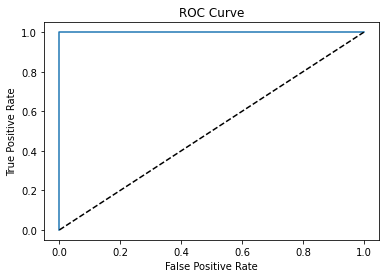

AUC is: 1.0


In [501]:
fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)

# Print ROC curve
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC is:', auc)

Conclusion: from the result above, the accuracy from the best model of L1 and variable selection using p-values are both 1.0 accuracy. But from the log of the accuracy for every iteration, I think variable selection usign p-values perform better. However, L1-penalized model is easier to implement becuase the run time is much faster than the variable selection. And we don't need to select features again after that.

### (c) Multi-class Classification (The Realistic Case)

#### i.Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible

In [522]:
def create_mult_df(df, l):
    train_multi = create_df(df, l)
    label = pd.Series(train_multi['label'])

    # change bending 1 and bending 2 to the same type
    for i in range(len(label)):
        if label[i] in ['bending1', 'bending2']:
            label[i] = 'bending'
    train_multi_select = train_multi[time_domain_df(train_multi)]
    return [train_multi_select, label]
a = create_mult_df(train_sets, 2)
a[0]

,mean1,median1,std1,mean2,median2,std2,mean3,median3,std3,mean4,...,std9,mean10,median10,std10,mean11,median11,std11,mean12,median12,std12
0,44.057167,44.500,1.556971,0.381042,0.470,0.329540,23.096792,24.000,2.410625,0.493458,...,3.270099,0.501167,0.43,0.599386,34.883375,36.000,2.298693,0.388333,0.000,0.478528
1,43.278875,45.000,3.473355,0.673292,0.485,0.634285,23.141250,23.750,3.123258,0.808042,...,4.183731,1.171792,0.87,1.079233,30.965708,30.415,3.760118,0.586083,0.470,0.491873
2,41.621208,42.330,3.118644,0.623083,0.500,0.489595,19.081458,19.500,5.102939,1.115083,...,2.725349,0.568667,0.47,0.456292,29.635833,29.750,2.062647,0.347500,0.430,0.363144
3,44.117042,45.000,1.359836,0.250042,0.000,0.314099,17.744167,18.000,4.010149,1.123000,...,2.438428,0.575708,0.43,0.730490,22.850875,23.250,1.881721,0.543875,0.500,0.473445
4,43.486208,43.710,1.281976,0.378667,0.470,0.284434,16.397250,16.875,3.469237,0.662958,...,3.933434,0.669750,0.47,0.744611,21.882042,21.750,1.929494,0.585750,0.500,0.487918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,34.966250,35.500,4.733014,4.207958,3.900,2.331940,15.125750,15.250,2.972166,3.270958,...,2.870303,3.143167,3.00,1.550629,16.168167,16.000,3.325780,3.430208,3.350,1.647979
65,34.737042,35.500,4.276717,4.217333,4.030,2.337759,15.595917,15.500,2.830028,3.181292,...,2.973009,3.004292,2.86,1.487694,16.175167,16.250,3.148561,3.225917,3.085,1.665326
66,33.886458,34.375,5.143776,4.332208,3.900,2.453111,15.158125,15.000,2.881089,3.249958,...,3.003681,3.146667,2.94,1.675791,15.829625,15.875,3.389030,3.274750,2.955,1.670593
67,34.836458,35.750,4.869092,4.257750,3.770,2.512633,15.181958,15.000,2.981010,3.131417,...,3.097689,3.159583,3.00,1.652816,15.996875,16.000,2.882455,3.409458,3.110,1.707089


In [545]:
models = []
scores = []
f1 = []
for l in np.arange(1, 21):
    table = create_mult_df(train_sets, l)
    train_x = table[0]
    train_x = normalize(train_x, norm = 'l1')
    train_y = table[1]
    
# I have to increase the max_iter beacuse of the ConvergenceWarning 
    model = LogisticRegressionCV(penalty='l1', cv = 5, solver='saga', random_state = 68,scoring = 'accuracy',\
                                max_iter = 7000, multi_class='multinomial').fit(train_x, train_y)
    score = model.score(train_x,train_y)
    F1_score = f1_score(train_y, model.predict(train_x),average="macro")
    scores.append(score)
    models.append(model)
    f1.append(F1_score)
    print('l:', l, ' score:', score, ' F1_score:', F1_score)

l: 1  score: 0.9710144927536232  F1_score: 0.9721980676328502
l: 2  score: 0.9855072463768116  F1_score: 0.986086956521739
l: 3  score: 0.9855072463768116  F1_score: 0.986086956521739
l: 4  score: 0.9855072463768116  F1_score: 0.986086956521739
l: 5  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 6  score: 0.9565217391304348  F1_score: 0.9577053140096617
l: 7  score: 0.8985507246376812  F1_score: 0.8969068358542044
l: 8  score: 0.9710144927536232  F1_score: 0.9700928044749556
l: 9  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 10  score: 0.9565217391304348  F1_score: 0.9556000508517671
l: 11  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 12  score: 0.9565217391304348  F1_score: 0.9577053140096617
l: 13  score: 0.9710144927536232  F1_score: 0.9722222222222222
l: 14  score: 0.9420289855072463  F1_score: 0.9403694843168529
l: 15  score: 0.927536231884058  F1_score: 0.9248788638262323
l: 16  score: 0.9420289855072463  F1_score: 0.9403694843168529
l: 17

In [628]:
# select the best l
best_score = max(scores)
best_l = 0
best_model = 0
best_p = 0
for i in range(len(scores)):
    if scores[i] == best_score:
        best_l = i + 1
        best_model = models[i]
        break
best_p = best_model.n_features_in_
print('\nbest l, p:', best_l, best_p)
print('the best score is ', round(best_score, 4), 'with f1-score:', round(f1[best_l-1], 4))


best l, p: 2 36
the best score is  0.9855 with f1-score: 0.9861


In [564]:
# using best l = 2
l = 2
table_test = create_mult_df(test_sets, l)
test_x = table_test[0]
test_x = normalize(test_x, norm = 'l1')
test_y = table_test[1]

score = best_model.score(test_x,test_y)
y_test_pred = best_model.predict(test_x)
cmatrix_test = confusion_matrix(test_y, y_test_pred)
print(cmatrix_test)
print('test accuracy for test set:', round(score,4))
print('test error for test set:', round(1-score,4))

[[3 0 0 1 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]
test accuracy for test set: 0.8421
test error for test set: 0.1579


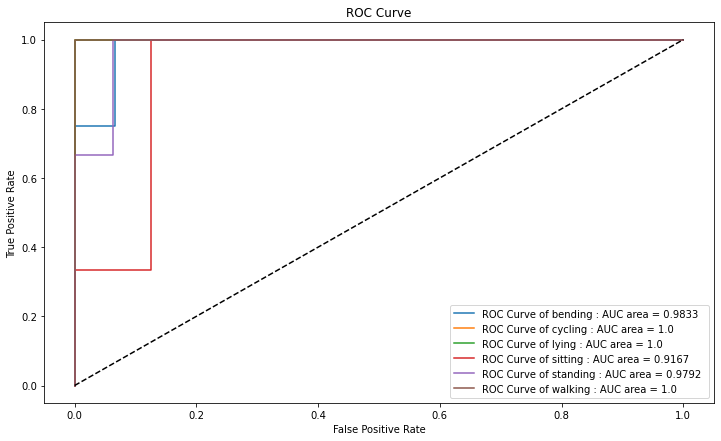

In [616]:
# resource:https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification
from sklearn import metrics
classes = best_model.classes_
# find probabilties of predicted y
y_prob = best_model.predict_proba(test_x)
fig, axes = plt.subplots(figsize=(12, 7))

for i in range(len(classes)):
    label = classes[i]
    test_each = test_y.apply(lambda x:1 if x==label else 0)
    fpr, tpr, thresholds = roc_curve(test_each, [x[i] for x in y_prob])
    auc = metrics.auc(fpr, tpr)
    axes.plot(fpr, tpr, label="ROC Curve of {} : AUC area = {} ".format(label, round(auc, 4)))
axes.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
    

#### ii.Repeat 2(c)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi-nomial priors and compare the results.

#### Multi-nomial Na ̈ıve Bayes’ classifier

In [631]:
# Multi-nomial Na ̈ıve Bayes’ classifier
from sklearn.naive_bayes import MultinomialNB
models_ii = []
scores_ii = []
f1_ii = []
for l in np.arange(1, 21):
    table = create_mult_df(train_sets, l)
    train_x = table[0]
    train_y = table[1]
    
# I have to increase the max_iter beacuse of the ConvergenceWarning 
    model_ii = MultinomialNB().fit(train_x, train_y)
    score_ii = model_ii.score(train_x,train_y)
    F1_score_ii = f1_score(train_y, model_ii.predict(train_x),average="macro")
    scores_ii.append(score_ii)
    models_ii.append(model_ii)
    f1_ii.append(F1_score_ii)
    print('l:', l, ' score:', score_ii, ' F1_score:', F1_score_ii)


l: 1  score: 0.8985507246376812  F1_score: 0.8944781144781144
l: 2  score: 0.9130434782608695  F1_score: 0.9101993620414673
l: 3  score: 0.9420289855072463  F1_score: 0.941632110579479
l: 4  score: 0.9420289855072463  F1_score: 0.941632110579479
l: 5  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 6  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 7  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 8  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 9  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 10  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 11  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 12  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 13  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 14  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 15  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 16  score: 0.9565217391304348  F1_score: 0.9555758962623951
l: 

In [632]:
# select the best l,p for multi-nomial naive bayes
best_score_multi = max(scores_ii)
best_l_multi = 0
best_model_multi = 0
best_p_multi = 0
for i in range(len(scores_ii)):
    if scores_ii[i] == best_score_multi:
        best_l_multi = i + 1
        best_model_multi = models_ii[i]
        break
best_p_multi = best_model_multi.n_features_in_
print('\nbest l, p:', best_l_multi, best_p_multi)
print('the best score is ', round(best_score_multi, 4), 'with f1-score:', round(f1_ii[best_l_multi-1], 4))


best l, p: 5 90
the best score is  0.9565 with f1-score: 0.9556


In [622]:
# using best l = 5
l = 5
table_test_multi = create_mult_df(test_sets, l)
test_x_multi = table_test_multi[0]
test_y_multi = table_test_multi[1]

score_multi = best_model_multi.score(test_x_multi,test_y_multi)
y_test_pred_multi = best_model_multi.predict(test_x_multi)
cmatrix_test_multi = confusion_matrix(test_y_multi, y_test_pred_multi)
print(cmatrix_test_multi)
print('test accuracy for test set:', round(score_multi,4))
print('test error for test set:', round(1-score_multi,4))

[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]
test accuracy for test set: 0.8947
test error for test set: 0.1053


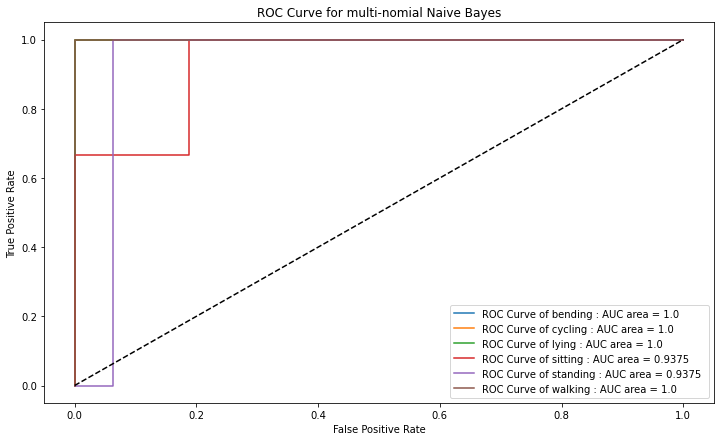

In [624]:
classes_multi = best_model_multi.classes_
# find probabilties of predicted y
y_prob_multi = best_model_multi.predict_proba(test_x_multi)
fig, axes = plt.subplots(figsize=(12, 7))

for i in range(len(classes_multi)):
    label_multi = classes_multi[i]
    test_each_multi = test_y_multi.apply(lambda x:1 if x==label_multi else 0)
    fpr, tpr, thresholds = roc_curve(test_each_multi, [x[i] for x in y_prob_multi])
    auc = metrics.auc(fpr, tpr)
    axes.plot(fpr, tpr, label="ROC Curve of {} : AUC area = {} ".format(label_multi, round(auc, 4)))
axes.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for multi-nomial Naive Bayes')
plt.legend()
plt.show()

#### Gaussian Naive Bayes

In [633]:
from sklearn.naive_bayes import GaussianNB
models_ii = []
scores_ii = []
f1_ii = []
for l in np.arange(1, 21):
    table = create_mult_df(train_sets, l)
    train_x = table[0]
    train_y = table[1]
    
# I have to increase the max_iter beacuse of the ConvergenceWarning 
    model_ii = GaussianNB().fit(train_x, train_y)
    score_ii = model_ii.score(train_x,train_y)
    F1_score_ii = f1_score(train_y, model_ii.predict(train_x),average="macro")
    scores_ii.append(score_ii)
    models_ii.append(model_ii)
    f1_ii.append(F1_score_ii)
    print('l:', l, ' score:', score_ii, ' F1_score:', F1_score_ii)

l: 1  score: 0.9565217391304348  F1_score: 0.9557516339869281
l: 2  score: 0.9855072463768116  F1_score: 0.9835294117647059
l: 3  score: 0.9710144927536232  F1_score: 0.969616368286445
l: 4  score: 0.9710144927536232  F1_score: 0.969616368286445
l: 5  score: 0.9710144927536232  F1_score: 0.969616368286445
l: 6  score: 0.9710144927536232  F1_score: 0.969616368286445
l: 7  score: 0.9855072463768116  F1_score: 0.9835294117647059
l: 8  score: 0.9710144927536232  F1_score: 0.969616368286445
l: 9  score: 0.9855072463768116  F1_score: 0.9835294117647059
l: 10  score: 0.9855072463768116  F1_score: 0.9835294117647059
l: 11  score: 0.9855072463768116  F1_score: 0.9835294117647059
l: 12  score: 0.9855072463768116  F1_score: 0.9835294117647059
l: 13  score: 0.9855072463768116  F1_score: 0.9835294117647059
l: 14  score: 0.9855072463768116  F1_score: 0.9835294117647059
l: 15  score: 0.9855072463768116  F1_score: 0.9835294117647059
l: 16  score: 0.9855072463768116  F1_score: 0.9835294117647059
l: 17 

In [634]:
# select the best l,p for gaussian naive bayes
best_score_gaus = max(scores_ii)
best_l_gaus = 0
best_model_gaus = 0
best_p_gaus = 0
for i in range(len(scores_ii)):
    if scores_ii[i] == best_score_gaus:
        best_l_gaus = i + 1
        best_model_gaus = models_ii[i]
        break
best_p_gaus = best_model_gaus.n_features_in_
print('\nbest l, p:', best_l_gaus, best_p_gaus)
print('the best score is ', round(best_score_gaus, 4), 'with f1-score:', f1_ii[best_l_gaus-1])


best l, p: 20 360
the best score is  1.0 with f1-score: 1.0


In [635]:
# using best l = 20
l = 20
table_test_gaus = create_mult_df(test_sets, l)
test_x_gaus = table_test_gaus[0]
test_y_gaus = table_test_gaus[1]

score_gaus = best_model_gaus.score(test_x_gaus,test_y_gaus)
y_test_pred_gaus = best_model_gaus.predict(test_x_gaus)
cmatrix_test_gaus = confusion_matrix(test_y_gaus, y_test_pred_gaus)
print(cmatrix_test_gaus)
print('test accuracy for test set:', round(score_gaus,4))
print('test error for test set:', round(1-score_gaus,4))

[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [1 0 2 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]
test accuracy for test set: 0.8421
test error for test set: 0.1579


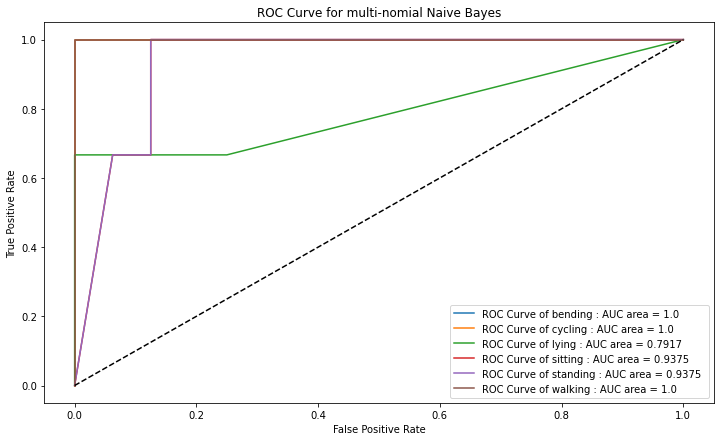

In [636]:
classes_gaus = best_model_gaus.classes_
# find probabilties of predicted y
y_prob_gaus = best_model_gaus.predict_proba(test_x_gaus)
fig, axes = plt.subplots(figsize=(12, 7))

for i in range(len(classes_gaus)):
    label_gaus = classes_gaus[i]
    test_each_gaus = test_y_gaus.apply(lambda x:1 if x==label_gaus else 0)
    fpr, tpr, thresholds = roc_curve(test_each_gaus, [x[i] for x in y_prob_gaus])
    auc = metrics.auc(fpr, tpr)
    axes.plot(fpr, tpr, label="ROC Curve of {} : AUC area = {} ".format(label_gaus, round(auc, 4)))
axes.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gaussian Naive Bayes')
plt.legend()
plt.show()

In [641]:
df_compare_score = pd.DataFrame({'L1-penalized logsitic regression':score, 'Multinomial Naive Bayes': score_multi, 'Gaussian Naive Bayes': score_gaus}, index = ['test accuracy'])
df_compare_score

,L1-penalized logsitic regression,Multinomial Naive Bayes,Gaussian Naive Bayes
test accuracy,0.842105,0.894737,0.842105


#### iii. Which method is better for multi-class classification in this problem?

From the test accuracy I have got above, multinomial naive bayes has the highest accuracy. I also compared using roc curve, multinomial naive bayes has the best performance and good auc area. Thus, multi-nomial naive bayes performs the best.

### 3.ISLR, 4.8.3

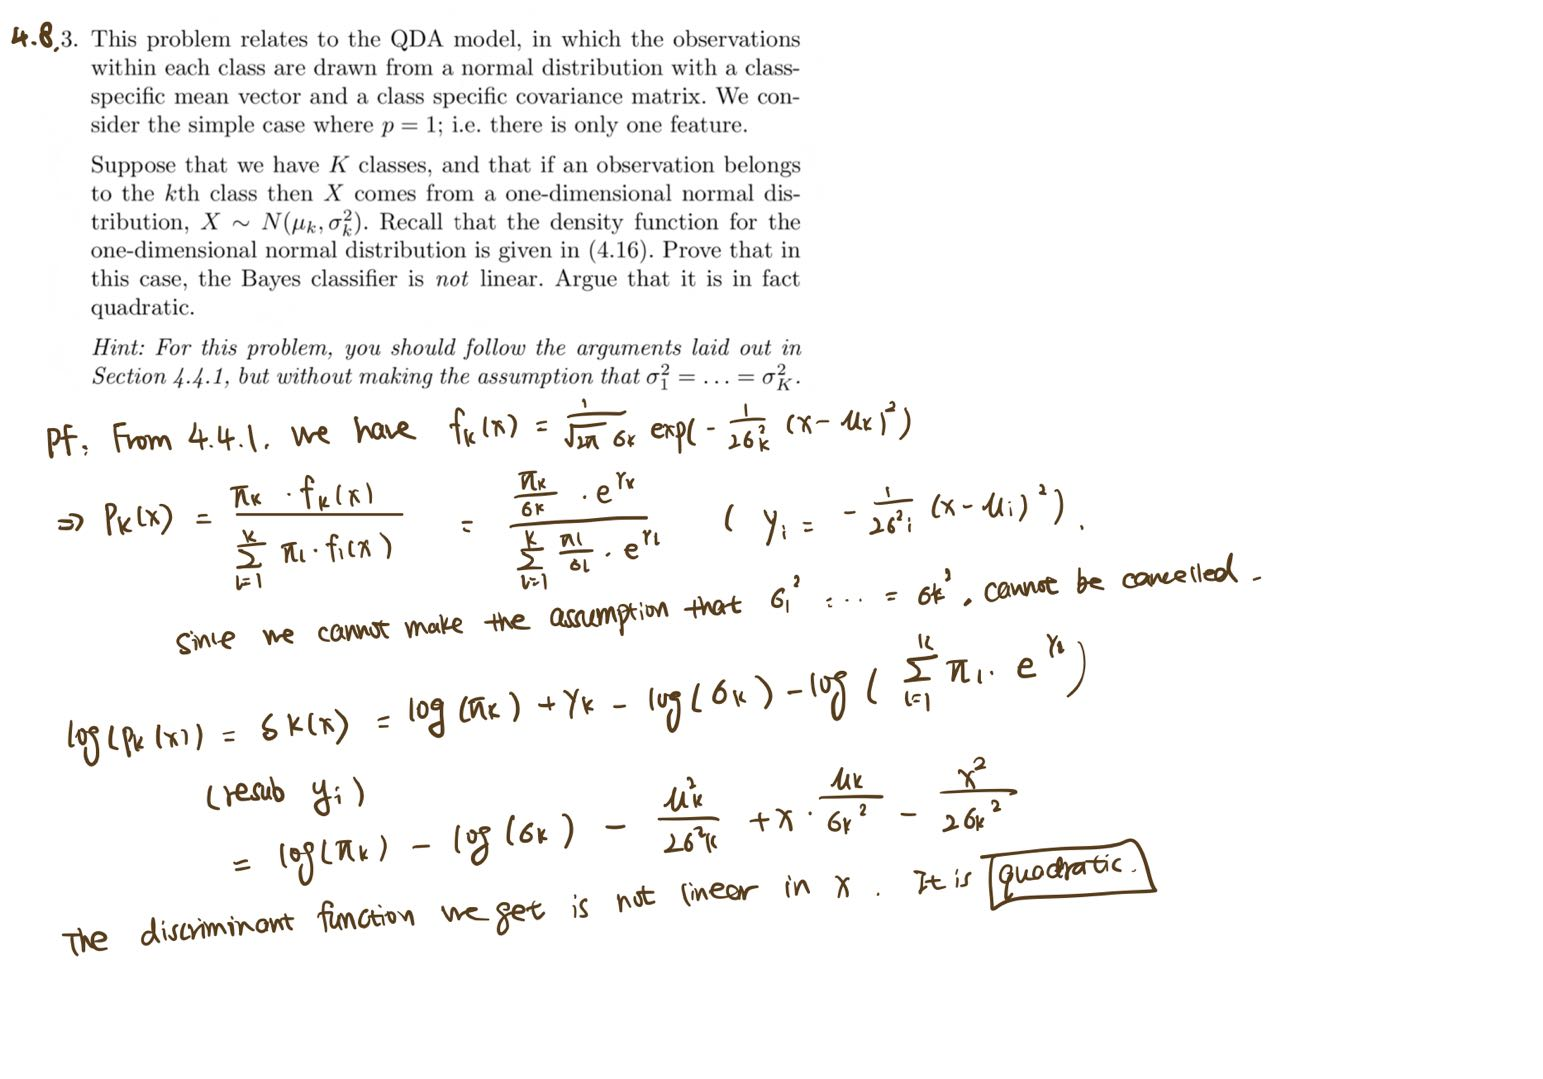

### 4.ISLR 4.8.7

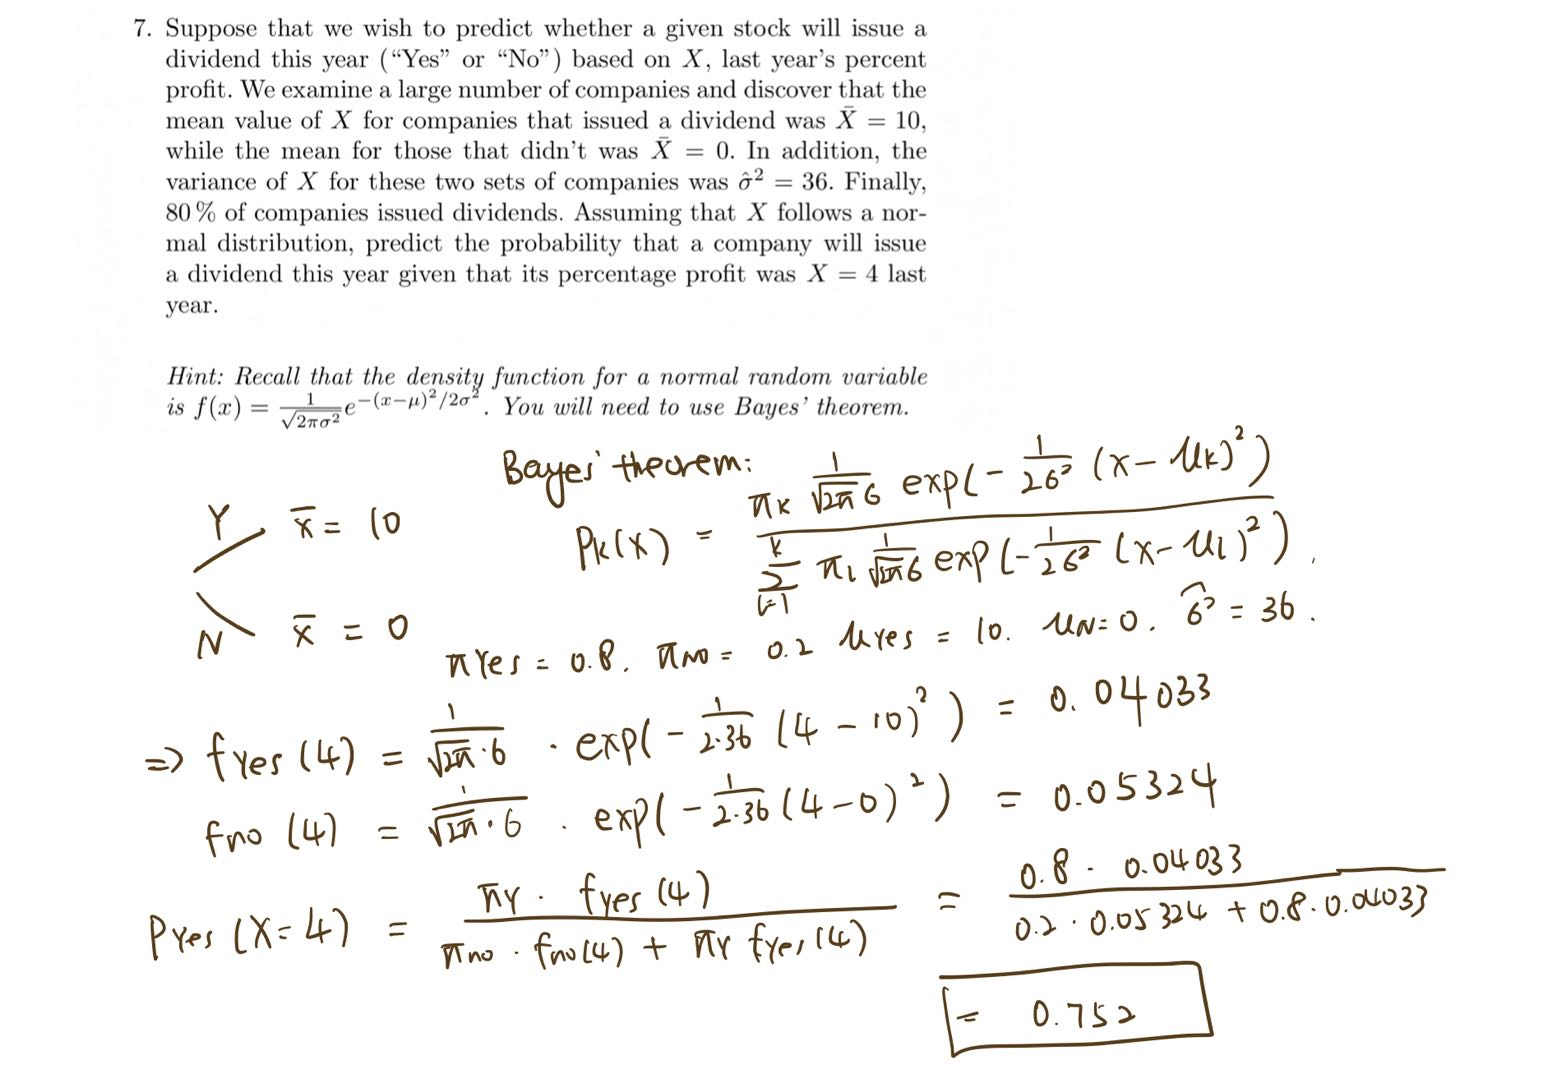